<a href="https://colab.research.google.com/github/udlbook/udlbook/blob/main/Notebooks/Chap11/11_3_Batch_Normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook 11.3: Batch normalization**

This notebook investigates the use of batch normalization in residual networks.

Work through the cells below, running each cell in turn. In various places you will see the words "TO DO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.



In [ ]:
# Run this if you're in a Colab to make a local copy of the MNIST 1D repository
!git clone https://github.com/greydanus/mnist1d

In [1]:
import numpy as np
import os
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import mnist1d
import random

In [2]:
args = mnist1d.data.get_dataset_args()
data = mnist1d.data.get_dataset(args, path='./mnist1d_data.pkl', download=False, regenerate=False)

# The training and test input and outputs are in
# data['x'], data['y'], data['x_test'], and data['y_test']
print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Length of each example: {}".format(data['x'].shape[-1]))

Successfully loaded data from ./mnist1d_data.pkl
Examples in training set: 4000
Examples in test set: 1000
Length of each example: 40


In [3]:
# Load in the data
train_data_x = data['x'].transpose()
train_data_y = data['y']
val_data_x = data['x_test'].transpose()
val_data_y = data['y_test']
# Print out sizes
print("Train data: %d examples (columns), each of which has %d dimensions (rows)"%((train_data_x.shape[1],train_data_x.shape[0])))
print("Validation data: %d examples (columns), each of which has %d dimensions (rows)"%((val_data_x.shape[1],val_data_x.shape[0])))

Train data: 4000 examples (columns), each of which has 40 dimensions (rows)
Validation data: 1000 examples (columns), each of which has 40 dimensions (rows)


In [5]:
def print_variance(name, data):
  # First dimension(rows) is batch elements
  # Second dimension(columns) is neurons.
  np_data = data.detach().numpy()
  # Compute variance across neurons and average these variances over members of the batch
  neuron_variance = np.mean(np.var(np_data, axis=0))
  # Print out the name and the variance
  print("%s variance=%f"%(name,neuron_variance))

In [6]:
# He initialization of weights
def weights_init(layer_in):
  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_uniform_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)

In [7]:
def run_one_step_of_model(model, x_train, y_train):
  # choose cross entropy loss function (equation 5.24 in the loss notes)
  loss_function = nn.CrossEntropyLoss()
  # construct SGD optimizer and initialize learning rate and momentum
  optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum=0.9)

  # load the data into a class that creates the batches
  data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=200, shuffle=True, worker_init_fn=np.random.seed(1))

  # Initialize model weights
  model.apply(weights_init)

  # Get a batch
  for i, data in enumerate(data_loader):
    # retrieve inputs and labels for this batch
    x_batch, y_batch = data
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward pass -- calculate model output
    pred = model(x_batch)
    # compute the loss
    loss = loss_function(pred, y_batch)
    # backward pass
    loss.backward()
    # SGD update
    optimizer.step()
    # Break out of this loop -- we just want to see the first
    # iteration, but usually we would continue
    break

In [8]:
# convert training data to torch tensors
x_train = torch.tensor(train_data_x.transpose().astype('float32'))
y_train = torch.tensor(train_data_y.astype('long'))

In [9]:
# This is a simple residual model with 5 residual branches in a row
class ResidualNetwork(torch.nn.Module):
  def __init__(self, input_size, output_size, hidden_size=100):
    super(ResidualNetwork, self).__init__()
    self.linear1 = nn.Linear(input_size, hidden_size)
    self.linear2 = nn.Linear(hidden_size, hidden_size)
    self.linear3 = nn.Linear(hidden_size, hidden_size)
    self.linear4 = nn.Linear(hidden_size, hidden_size)
    self.linear5 = nn.Linear(hidden_size, hidden_size)
    self.linear6 = nn.Linear(hidden_size, hidden_size)
    self.linear7 = nn.Linear(hidden_size, output_size)

  def count_params(self):
    return sum([p.view(-1).shape[0] for p in self.parameters()])

  def forward(self, x):
    print_variance("Input",x)
    f = self.linear1(x)
    print_variance("First preactivation",f)
    res1 = f+ self.linear2(f.relu())
    print_variance("After first residual connection",res1)
    res2 = res1 + self.linear3(res1.relu())
    print_variance("After second residual connection",res2)
    res3 = res2 + self.linear4(res2.relu())
    print_variance("After third residual connection",res3)
    res4 = res3 + self.linear5(res3.relu())
    print_variance("After fourth residual connection",res4)
    res5 = res4 + self.linear6(res4.relu())
    print_variance("After fifth residual connection",res5)
    return self.linear7(res5)

In [10]:
# Define the model and run for one step
# Monitoring the variance at each point in the network
n_hidden = 100
n_input = 40
n_output = 10
model = ResidualNetwork(n_input, n_output, n_hidden)
run_one_step_of_model(model, x_train, y_train)

Input variance=0.958191
First preactivation variance=1.882302
After first residual connection variance=3.263637
After second residual connection variance=5.482897
After third residual connection variance=9.971355
After fourth residual connection variance=19.020630
After fifth residual connection variance=34.580872


Notice that the variance roughly doubles at each step so it increases exponentially as in figure 11.6b in the book.

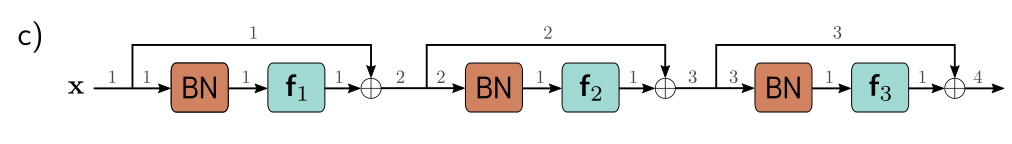

In [15]:
# TODO Adapt the residual network below to add a batch norm operation
# before the contents of each residual link as in figure 11.6c in the book
# Use the torch function nn.BatchNorm1d
class ResidualNetworkWithBatchNorm(torch.nn.Module):
    def __init__(self, input_size, output_size, hidden_size=100):
        super(ResidualNetworkWithBatchNorm, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.batchNorm1 = nn.BatchNorm1d(hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.batchNorm2 = nn.BatchNorm1d(hidden_size) 
        self.linear3 = nn.Linear(hidden_size, hidden_size)
        self.batchNorm3 = nn.BatchNorm1d(hidden_size) 
        self.linear4 = nn.Linear(hidden_size, hidden_size)
        self.batchNorm4 = nn.BatchNorm1d(hidden_size) 
        self.linear5 = nn.Linear(hidden_size, hidden_size)
        self.batchNorm5 = nn.BatchNorm1d(hidden_size) 
        self.linear6 = nn.Linear(hidden_size, hidden_size)
        self.batchNorm6 = nn.BatchNorm1d(hidden_size) 
        self.linear7 = nn.Linear(hidden_size, output_size)
    
    def count_params(self):
        return sum([p.view(-1).shape[0] for p in self.parameters()])
    
    def forward(self, x):
        print_variance("Input",x)
        f = self.linear1(x)
        print_variance("First preactivation",f)
        res1 = f+ self.linear2(self.batchNorm2(f).relu())
        print_variance("After first residual connection",res1)
        res2 = res1 + self.linear3(self.batchNorm3(res1).relu())
        print_variance("After second residual connection",res2)
        res3 = res2 + self.linear4(self.batchNorm4(res2).relu())
        print_variance("After third residual connection",res3)
        res4 = res3 + self.linear5(self.batchNorm5(res3).relu())
        print_variance("After fourth residual connection",res4)
        res5 = res4 + self.linear6(self.batchNorm6(res4).relu())
        print_variance("After fifth residual connection",res5)
        return self.linear7(res5)

In [16]:
# Define the model
n_hidden = 100
n_input = 40
n_output = 10
model = ResidualNetworkWithBatchNorm(n_input, n_output, n_hidden)
run_one_step_of_model(model, x_train, y_train)

Input variance=1.028562
First preactivation variance=2.029478
After first residual connection variance=2.803043
After second residual connection variance=3.466902
After third residual connection variance=4.137806
After fourth residual connection variance=4.829071
After fifth residual connection variance=5.661638


Note that the variance now increases linearly as in figure 11.6c.